In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/MYK/Desktop/IRES/scripts')

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as si
import scipy.special as ss
import scipy.stats as st
from scipy.fftpack import fft, ifft
import utils as u
import profiles as p
import csv
from astropy.modeling import models, fitting
import glob
import scipy.optimize as so
import pywt
import gaussfit as gf

In [2]:
#list of all .prof files
filenames = glob.glob('./J0332+5434/*.prof')
#list to store profile objects from read in data
profs = []

#read in data, save flux values into numpy array
for i,name in enumerate(filenames):   
    with open (name, 'r') as f:
        data = f.readlines()
        
        #save, then remove first line of metadata
        header = data[0]
        data.remove(data[0])
        
        #remove indexing, newline characters and save to array
        nbins = len(data)
        single_prof = np.zeros(nbins)
        for i in range(nbins):
            single_prof[i] = data[i].split(" ")[1].split('\n')[0]
        
        #Feed info into profile object, append object to data list
        profs.append(p.profile(header, single_prof))

#remove bad data (from visual inspection)
bad_indices = [0,17,20,28,32,33,47,52,55,60,61,62,69,70,71,72,75,76,77,78,79,83]
ct = 0 
for i in bad_indices:
    profs.remove(profs[i-ct]) #i-ct because once remove an element, the total list length reduces by 1
    ct += 1

profs = np.array(profs)

In [3]:
#save MJD array to use in KS test plot
#mjd_arr = np.array([i.MJD for i in profs])
#np.savetxt('J0332_MJD.txt', mjd_arr)

# Phase align in Fourier Domain

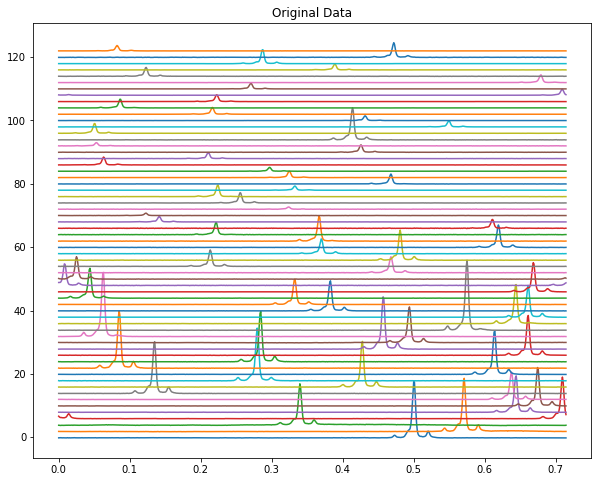

In [4]:
x = profs[0].domain

plt.figure(figsize=(10,8))
for i,val in enumerate(profs):
    plt.plot(x,val.profile - np.mean(val.profile) + i*2)
plt.title('Original Data')
plt.show()

In [5]:
profs2 = u.phase_shift(profs, basis=2, N=profs[0].nbins, P = profs[0].p)

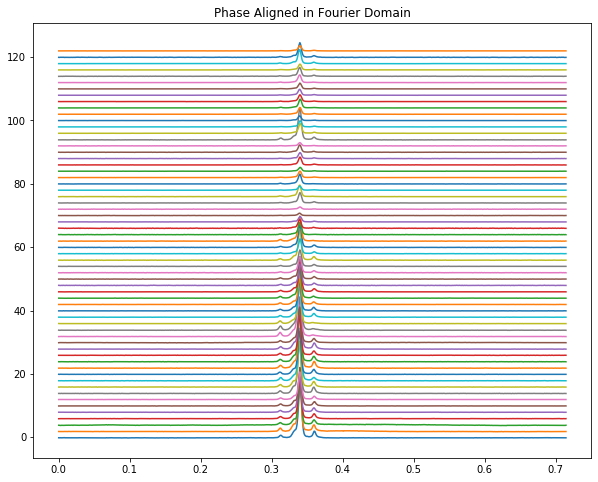

In [6]:
plt.figure(figsize=(10,8))
for i,val in enumerate(profs2):
    plt.plot(x,val.profile - np.mean(val.profile) + i*2)
plt.title("Phase Aligned in Fourier Domain")
plt.show()

## Save 2D array into .txt for use in KS_test

# Create Gaussian fit for each profile

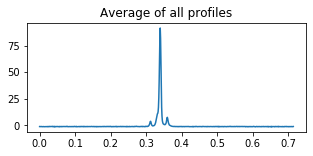

In [7]:
#calib is all the profiles with their means subtracted, so we can compare relative amp
#also normalize data (divide by integral)
#still a 2D array nprof x nbins
calib = []

for i in range(len(profs2)):
    meansub = profs2[i].profile - np.mean(profs2[i].profile) # calibrate all profiles
    calib.append( meansub / np.trapz(meansub)) # normalize
    
calib = np.array(calib)

#save calib to use in KS_test
np.savetxt('J0332_profs.txt', calib)

#avg is the average profile of all 63 profiles
avg = np.average(calib, axis=0)

plt.figure(figsize=(5,2))
plt.plot(x,avg)
plt.title('Average of all profiles')
plt.show()

#can visually see average profile has peaks with mean at ~ .3, .33, .37

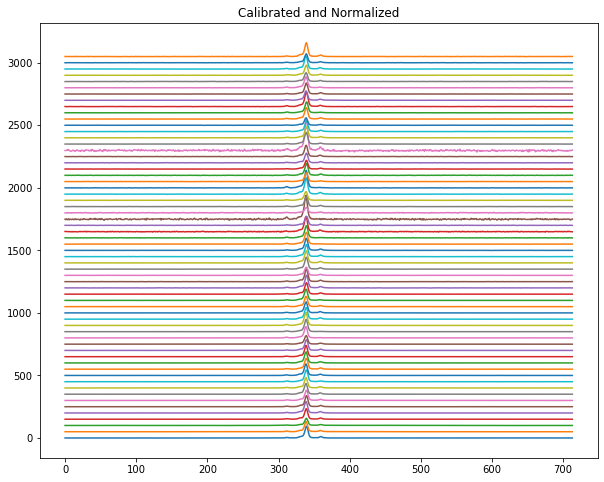

In [8]:
plt.figure(figsize=(10,8))
for i,val in enumerate(calib):
    plt.plot(val + i*50)
plt.title('Calibrated and Normalized')
plt.show()

# Gaussian fitting using scipy curve_fit

In [9]:
def gaussian(x, a1, a2, a3, a4, a5, m1, m2, m3, m4, m5, sd1, sd2, sd3, sd4, sd5):
    model = models.Gaussian1D(a1, m1, sd1) + models.Gaussian1D(a2, m2, sd2) + \
            models.Gaussian1D(a3, m3, sd3) + models.Gaussian1D(a4, m4, sd4) + \
            models.Gaussian1D(a5, m5, sd5)
    return model(x)

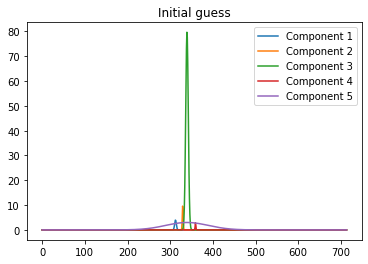

In [17]:
#Our gaussian model guesses
#amp = [1, 2.5, 17, 5, .8]
amp = [4, 10, 80, 3, 3]
mean = [.313, .33, .34, .36,.34]
stddev = [.002, .001, .003, .0008,.05]

for i in range(len(amp)):
    g_init = models.Gaussian1D(amp[i], mean[i], stddev[i])
    plt.plot(g_init(x), label='Component {}'.format(i+1))
    plt.legend()
    plt.title('Initial guess')

In [ ]:
#use curvefit on each profile, save resulting data and metadata as gaussfit objects
nprofs = len(calib)
mjd = np.loadtxt('J0332_MJD.txt')
fit_results = []

for i, profile in enumerate(calib):
    print(i)
    params, cov = so.curve_fit(gaussian, x, profile, p0=[amp, mean, stddev])
    fit_obj = gf.gaussfit(profile, params, cov, mjd=mjd[i])
    fit_results.append(fit_obj)

In [23]:
fit_obj.params

array([3.33600301e+00, 1.17979128e+01, 8.88963985e+01, 9.77863824e+00,
       2.96437837e+00, 3.12850336e-01, 3.33974510e-01, 3.40196129e-01,
       3.60245651e-01, 3.42828471e-01, 1.53733338e-03, 3.80060572e-03,
       2.07827166e-03, 1.99784021e-03, 6.12266171e-03])

Only index 35, or 58425 MJD failed to have proper cov

In [25]:
#create and store profile given fitted gaussian parameters
fit_prof = []
for i in fit_results:
    g_init = models.Gaussian1D(0,0,0)
    for j in range(len(amp)):
        g_init += models.Gaussian1D(i.params[j], i.params[j+5], i.params[j+10])
    fit_prof.append(g_init(x))

In [26]:
#Append errors of each gaussfit object as attribute
for i in fit_results:
    i.errors = np.sqrt(np.diag(i.cov))

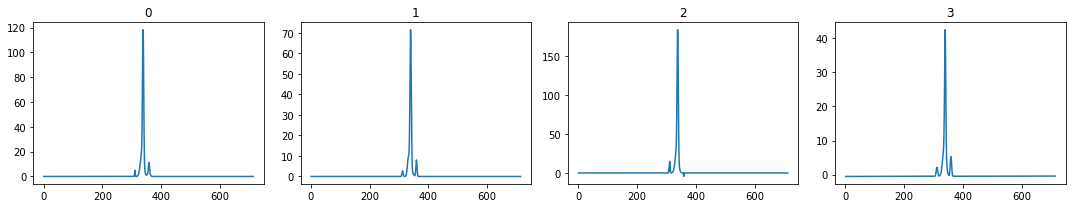

In [64]:
u.gridplot(fit_prof[33:37], 4 , hist=False, figsize=(15,3))
#index 35 has negative peak

(0.3, 0.4)

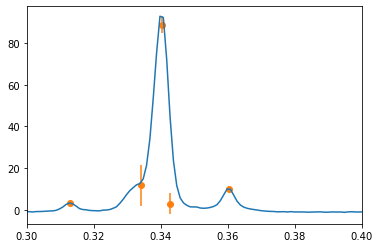

In [81]:
#plot amplitude ratios for each gaussian component
p = fit_results[0]
plt.plot(x, p.profile)
plt.errorbar(p.params[5:10], p.params[:5], yerr=p.errors[:5], fmt='o', barsabove=True)
plt.xlim(0.3,.4)

## Below is gaussian fitting using Astropy, but issue with covariance matrix not showing up, so use scipy.curve_fit which astropy is acting as wrapper form

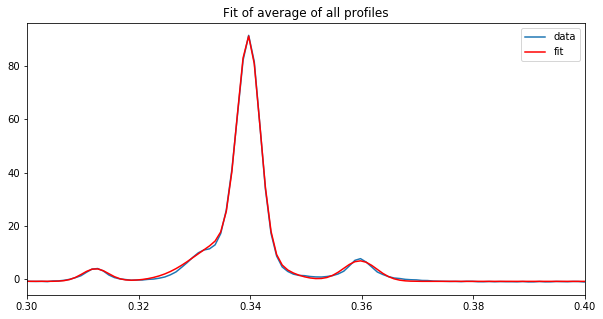

In [9]:
#amp = [1,2.5,17,3]
#mean = [.313, .33, .34, .36]
#stddev = [.003,.001, .003, .0008]

amp = [1, 2.5, 17, 3, .8]
mean = [.313, .33, .34, .36,.34]
stddev = [.002, .001, .003, .0008,.05]

#k = u.gaussian_fit(x, avg,amp, mean, stddev)

g_init = models.Gaussian1D(amplitude=0)
for i in range(len(amp)):
    g_init += models.Gaussian1D(amplitude=amp[i], mean=mean[i], stddev=stddev[i])
fitter = fitting.LevMarLSQFitter()
g = fitter(g_init, x, avg)

plt.figure(figsize=(10,5))
plt.plot(x, avg, label='data')
plt.plot(x, g(x), 'r', label='fit')
plt.title('Fit of average of all profiles')
plt.xlim((.3,.4))
plt.legend()
plt.show()

#res = k(x) - avg
#plt.plot(x,res)
#plt.show()

In [10]:
fitter.fit_info
fitter.fit_info['message']

'Number of calls to function has reached maxfev = 100.'

# Fit all calibrated profiles

In [11]:
g = [] #store fitted object

for i, val in enumerate(calib):
    fitted = u.gaussian_fit(x, val, amp, mean, stddev)
    g.append(fitted)

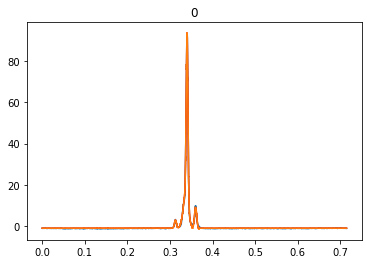

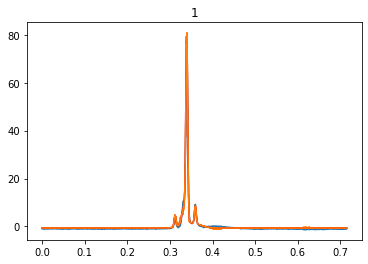

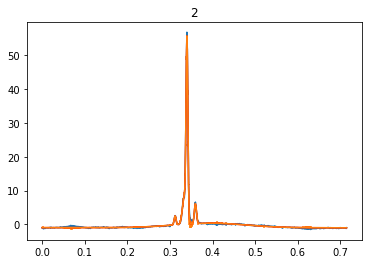

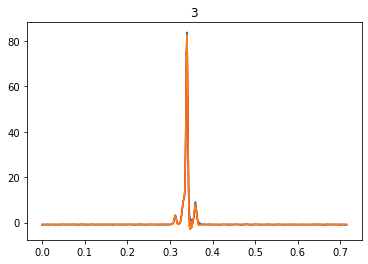

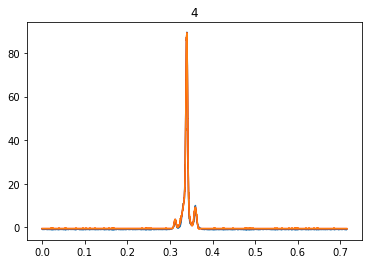

In [12]:
for i,val in enumerate(calib[:5]):
    plt.plot(x, val, label='data')
    plt.plot(x, g[i](x), 'r', label='fit')
    resids = g[i](x) - val
    plt.errorbar(x,g[i](x),yerr=resids)
    plt.title(i)
    plt.show()

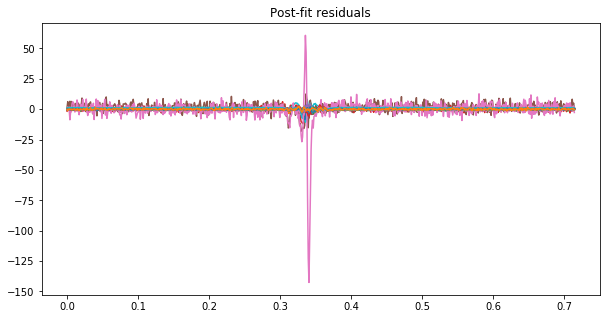

In [13]:
plt.figure(figsize=(10,5))
for i,val in enumerate(calib):
    plt.plot(x,g[i](x) - val)
plt.title('Post-fit residuals')
plt.show()
#do chi square test on residuals

# Fitted params as function of epoch

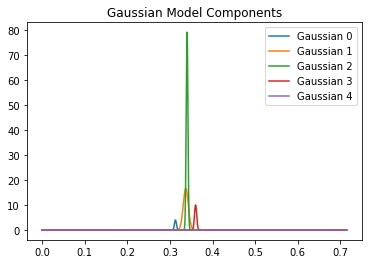

In [14]:
nprofs = len(calib)
domain = [i.MJD for i in profs2]
ngauss = 5

for i in range(ngauss):
    m = models.Gaussian1D(amplitude=g[0].parameters[3*(i+1)], mean=g[0].parameters[3*(i+1)+1], 
                          stddev=g[0].parameters[3*(i+1)+2])
    plt.plot(x, m(x),label='Gaussian %s' %i)
plt.title('Gaussian Model Components')
plt.legend()
plt.show()

## Display errorbars

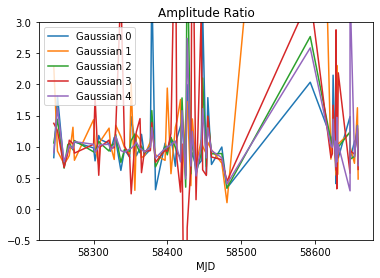

In [15]:
#ratio of amplitude as function of epoch
for i in range(ngauss):
    ratio = []
    for j in range(nprofs-1):#-1 because ratio
        ratio.append(g[j].parameters[3*(i+1)] / g[j+1].parameters[3*(i+1)])
    #domain[1:] because also -1 like ratio, so at each epoch, ratio value = change from this epoch to one b4
    plt.plot(domain[1:], ratio, label='Gaussian %s' %i)
        
plt.legend()
plt.title('Amplitude Ratio')
plt.xlabel('MJD')
plt.ylim(-.5, 3)
plt.show()

## Miscellaneous code

In [16]:
#calculate residuals
#nprofs x nbins 2D array
#resid_tuple = tuple(calib[i] - g[i](x) for i in range(nprofs))
#resids = np.vstack(resid_tuple)
#u.gridplot(resids, 3, figsize=(15,70))

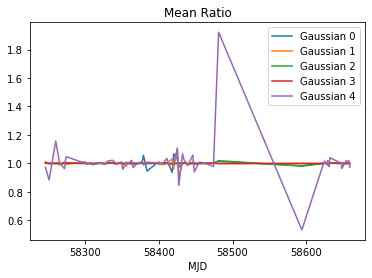

In [17]:
#ratio of mean as function of epoch
for i in range(ngauss):
    ratio = []
    for j in range(nprofs-1):#-1 because ratio
        ratio.append(g[j].parameters[3*(i+1)+1] / g[j+1].parameters[3*(i+1)+1])
    #domain[1:] because also -1 like ratio, so at each epoch, ratio value = change from this epoch to one b4
    plt.plot(domain[1:], ratio, label='Gaussian %s' %i)
        
plt.legend()
plt.title('Mean Ratio')
plt.xlabel('MJD')
plt.show()

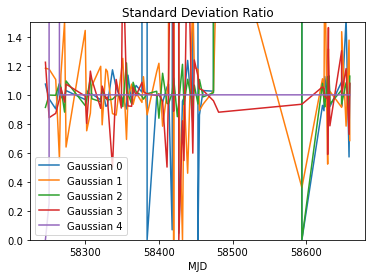

In [18]:
#ratio of sd as function of epoch
for i in range(ngauss):
    ratio = []
    for j in range(nprofs-1):#-1 because ratio
        ratio.append(g[j].parameters[3*(i+1)+2] / g[j+1].parameters[3*(i+1)+2])
    #domain[1:] because also -1 like ratio, so at each epoch, ratio value = change from this epoch to one b4
    plt.plot(domain[1:], ratio, label='Gaussian %s' %i)
        
plt.legend()
plt.title('Standard Deviation Ratio')
plt.xlabel('MJD')
plt.ylim(0,1.5)
plt.show()